In [ ]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

#differentiation library that supports all differentiable Tensor operations in torch
from torch.autograd import Variable

#a neural networks library integrated with autograd functionality
import torch.nn as nn
import torch.nn.functional as F

#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim

#scientific computing library for Python
import numpy as np

from torch.utils.data import Dataset

#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline
plt.ion() #Turn interactive mode on.


In [ ]:
####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#inbuilt dataset class for reading CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='../../data/lab9', train=True,
                                        download=True, transform=transform)

#dataloader for Batching, shuffling and loading data in parallel
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

####test data
testset = torchvision.datasets.CIFAR10(root='../../data/lab9', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/lab9/cifar-10-python.tar.gz to ../../data/lab9


GroundTruth:    cat  ship  ship plane


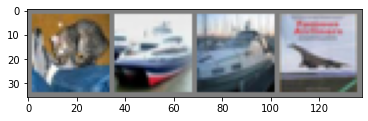

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
class Net(nn.Module):

    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self):
        super(Net, self).__init__()

        #calling conv2d module for convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,stride=1,padding=0,bias=True)

        #calling MaxPool2d module for max pooling with downsampling of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, 5)

        #fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    #defining the structure of the network
    def forward(self, x):

        #Applying relu activation after each conv layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        #reshaping to 1d for giving input to fully connected units
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
#Printing the parameter values
params = list(net.parameters())
print(params[0].size())  # conv1's .weight


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

torch.Size([6, 3, 5, 5])


[1,   200] loss: 2.241
[1,   400] loss: 1.847
[1,   600] loss: 1.639
[2,   200] loss: 1.491
[2,   400] loss: 1.438
[2,   600] loss: 1.406
[3,   200] loss: 1.300
[3,   400] loss: 1.310
[3,   600] loss: 1.251
[4,   200] loss: 1.178
[4,   400] loss: 1.169
[4,   600] loss: 1.174
[5,   200] loss: 1.096
[5,   400] loss: 1.104
[5,   600] loss: 1.093


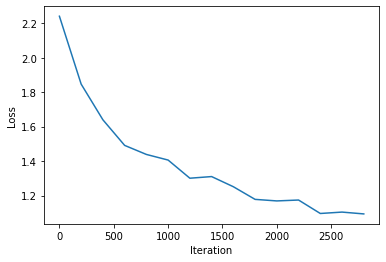

Finished Training


In [ ]:
plotIter = 200
plotIterCntr = 0
numEpochs = 5
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

#Transferring the model to GPU
net.cuda()

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0

#Plotting the training graph
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

In [ ]:
## Prediction of accuracy
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        # print('Batch [%4d / %4d]' % (i+1, len(testloader)))
        images, labels = data
        outputs = net(images.cuda())
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.numpy())

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[569,  26,  75,  14,  46,   6,  13,  21, 159,  71],
       [  8, 707,  13,   9,   8,   3,  20,  11,  75, 146],
       [ 49,  17, 524,  45, 148,  62,  85,  38,  15,  17],
       [  9,  12,  83, 366, 118, 193, 108,  53,  17,  41],
       [ 18,  12,  95,  50, 569,  43,  90, 103,  13,   7],
       [  6,   5,  89, 184,  76, 498,  50,  74,   8,  10],
       [  0,  16,  49,  45,  90,  31, 737,  17,   9,   6],
       [  3,   6,  47,  46,  80,  84,  17, 688,   7,  22],
       [ 46,  51,  22,  23,  12,  10,   9,   6, 790,  31],
       [ 19, 105,  24,  23,  12,   8,  15,  29,  56, 709]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


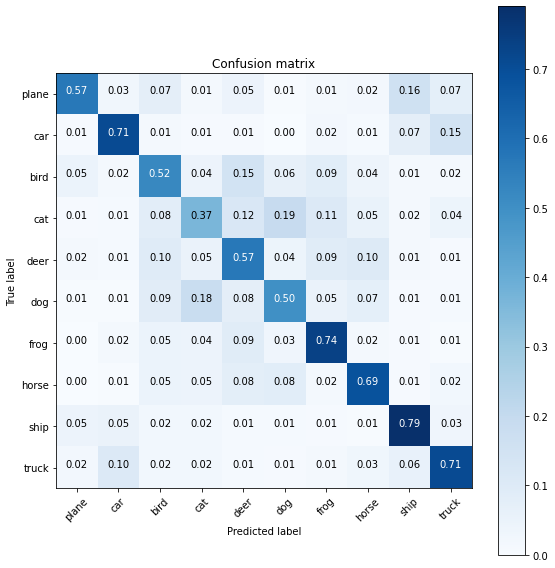

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)

# Exercise
- Evaluate the model after converting all test images to grayscale and report the test accuracy and confusion matrix

# Effect of Bias on Model Predictions

In [ ]:
class BiasedDataset(Dataset):


    def __init__(self, train=True, test_gray=False):
        self.train = train
        self.test_gray = test_gray
        self.load_data()

    def load_data(self):
        self.ds1 = torchvision.datasets.CIFAR10(root='./lab9', train=self.train,
                                        download=True, transform=transforms.Compose([]))
        self.transform1 = transforms.Compose([transforms.RandomGrayscale(p=0.05), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform2 = transforms.Compose([transforms.RandomGrayscale(p=0.95), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.test_transform1 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.test_transform2 = transforms.Compose([transforms.Grayscale(3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.ds1_len = len(self.ds1)

    def __len__(self):
        return self.ds1_len

    def __getitem__(self, idx):


        (img,label)=self.ds1[idx]


        if(self.train):
            if(label>=5):
              img = self.transform1(img)
            else:
              img = self.transform2(img)
        else:
            if(self.test_gray):
              img = self.transform2(img)
            else:
              img = self.transform1(img)



        return img, label

In [ ]:
ds_train = BiasedDataset(train=True)
ds_test = BiasedDataset(train=False)
ds_test_gray = BiasedDataset(train=False, test_gray=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(ds_train), len(ds_test)

(50000, 10000)

In [ ]:
trainloader = torch.utils.data.DataLoader(ds_train, batch_size=64,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=64,shuffle=False, num_workers=2)
testloader_gray = torch.utils.data.DataLoader(ds_test_gray, batch_size=64,shuffle=False, num_workers=2)

GroundTruth:    cat  frog   car  frog  deer truck   car truck


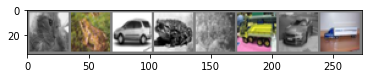

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images[:8]))))

GroundTruth:    cat  ship  ship plane


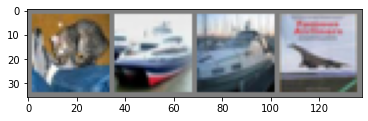

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images[:4]))))

GroundTruth:    cat  ship  ship plane


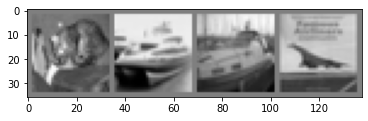

In [ ]:
dataiter = iter(testloader_gray)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images[:4]))))

In [ ]:
biasednet = Net()

print(biasednet)
#Printing the parameter values
params = list(biasednet.parameters())
print(params[0].size())  # conv1's .weight


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(biasednet.parameters(), lr=0.01, momentum=0.9)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([6, 3, 5, 5])


In [ ]:
len(trainloader)

782

[1,   200] loss: 2.249
[1,   400] loss: 1.867
[1,   600] loss: 1.510
[2,   200] loss: 1.231
[2,   400] loss: 1.160
[2,   600] loss: 1.141
[3,   200] loss: 1.069
[3,   400] loss: 1.054
[3,   600] loss: 1.024
[4,   200] loss: 0.979
[4,   400] loss: 0.958
[4,   600] loss: 0.963
[5,   200] loss: 0.921
[5,   400] loss: 0.890
[5,   600] loss: 0.921


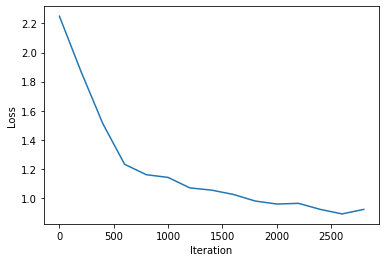

Finished Training


In [ ]:
plotIter = 200
plotIterCntr = 0
numEpochs = 5
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

#Transferring the model to GPU
biasednet.cuda()

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = biasednet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0

#Plotting the training graph
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')

## Evaluation on Normal Test Image

In [ ]:
## Prediction of accuracy
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in testloader:
    images, labels = data
    outputs = biasednet(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 42 %


In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader):
        # print('Batch [%4d / %4d]' % (i+1, len(testloader)))

        # inputs, labels = data['pointcloud'].float(), data['category']
        images, labels = data
        outputs = biasednet(images.cuda())
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[154,   0,  13,  13,   5, 102,  39,  59, 456, 159],
       [  7, 173,   0,   4,   4,  39,  24,  14,  93, 642],
       [  6,   0,  57,  18,  17, 375, 331,  98,  75,  23],
       [  2,   2,   9,  83,   6, 504, 271,  45,  47,  31],
       [  5,   0,   9,  21,  59, 222, 483, 146,  41,  14],
       [  2,   1,   8,  63,   4, 718, 128,  52,  16,   8],
       [  3,   1,  12,  22,  10,  81, 833,  15,  18,   5],
       [  5,   2,   8,  19,  14, 219,  78, 618,  11,  26],
       [ 32,   4,   2,  10,   1,  38,  18,  13, 789,  93],
       [ 13,  15,   3,  10,   6,  42,  57,  42,  59, 753]])

Normalized confusion matrix


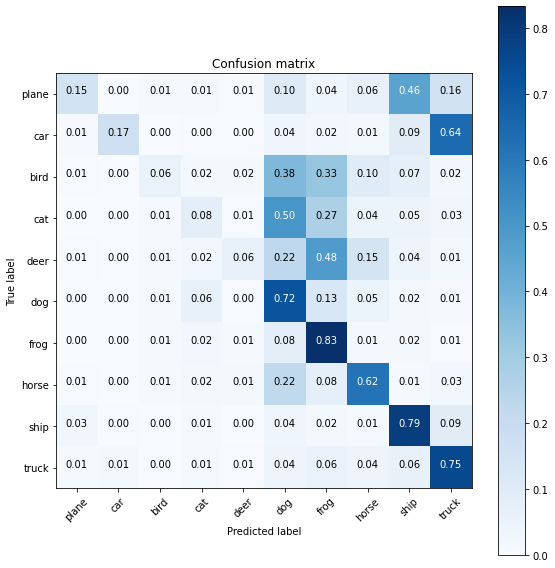

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)

## Evaluation on Gray Test Images

In [ ]:
## Prediction of accuracy
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in testloader_gray:
    images, labels = data
    outputs = biasednet(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 39 %


In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader_gray):
        images, labels = data
        outputs = biasednet(images.cuda())
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[647,  30,  80,  90,  54,   7,   2,   6,  59,  25],
       [ 67, 694,  21,  79,  31,   2,   5,   1,  18,  82],
       [ 78,   9, 412, 311, 134,  24,  19,   2,   9,   2],
       [ 41,  12,  91, 706,  94,  22,  12,   4,  11,   7],
       [ 46,   8, 119, 286, 473,  19,  33,  12,   2,   2],
       [ 16,   4, 110, 738,  62,  54,  10,   4,   2,   0],
       [ 27,  26, 143, 434, 177,   1, 180,   3,   7,   2],
       [ 55,  16,  87, 356, 335,  24,   3, 114,   5,   5],
       [394, 109,  46,  94,  27,   4,   0,   3, 302,  21],
       [111, 268,  29, 170,  34,   2,  13,   1,  22, 350]])

Normalized confusion matrix


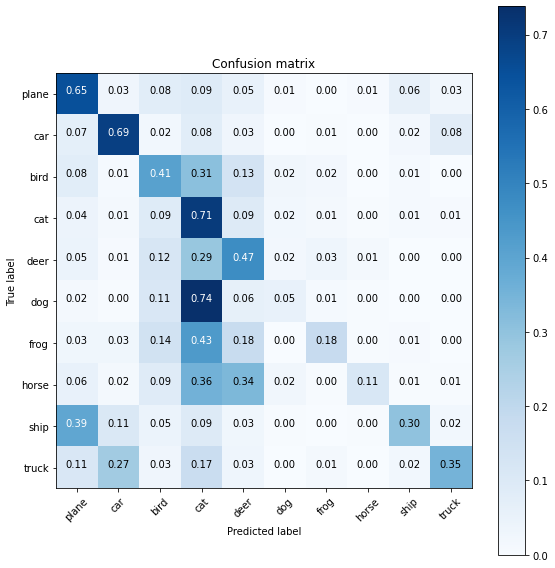

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)

# Exercise

- Swap the transforms.RandomGrayscale probability between first 5 and last 5 classes and observe the new confusion matrix
- Change the transforms.RandomGrayscale probability to 50\% for the training images all classes and check the effect on the confusion matrix